In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from network import Modele

%load_ext autoreload
# Load the TensorBoard notebook extension

%autoreload 2

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
#Simple Dataset class for our change detection dataset

class ChangeDetectionDataset(Dataset):
    def __init__(self, csv_file="data.csv", data_dir="./data", batch_size=1, transform=None, crop_size=128):
        self.data = pd.read_csv(csv_file)
        self.data_dir = data_dir
        self.transform = transform
        self.batch_size = batch_size
        self.crop_size = crop_size
    def __len__(self):
        return len(self.data)

    def random_crop(self, img1, img2, cm, size):
        x = np.random.randint(0, img1.shape[2]-size)
        y = np.random.randint(0, img1.shape[1]-size)
        img1 = img1[:,y:y+size, x:x+size]
        img2 = img2[:,y:y+size, x:x+size]
        cm = cm[0:1, y:y+size, x:x+size]
        return img1, img2, cm

    def __getitem__(self, idx):
        img1 = read_image(self.data_dir+'/'+self.data.iloc[idx,0])
        img2 = read_image(self.data_dir+'/'+self.data.iloc[idx,1])
        cm = read_image(self.data_dir+'/'+self.data.iloc[idx,2])


        img1Tensor = torch.zeros((3, self.crop_size, self.crop_size), dtype=torch.float32)
        img2Tensor = torch.zeros((3, self.crop_size, self.crop_size), dtype=torch.float32)
        cmTensor = torch.zeros((1, self.crop_size, self.crop_size), dtype=torch.float32)

        
        crop1, crop2, cropcm = self.random_crop(img1[:,:,:], img2[:,:,:], cm[:,:,:], self.crop_size)
        img1Tensor[:,:,:] = crop1.float()/255
        img2Tensor[:,:,:] = crop2.float()/255
        cmTensor[:,:,:] = cropcm.float()
        #apply the same transformation to all images as batch dimension
        return img1Tensor, img2Tensor, cmTensor
        

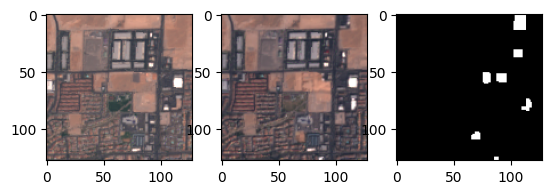

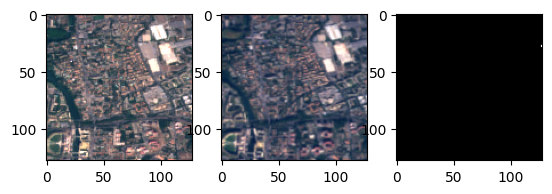

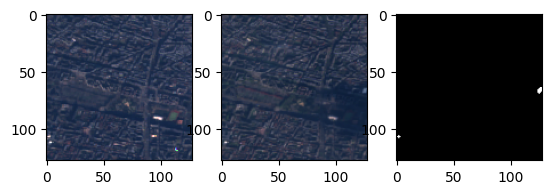

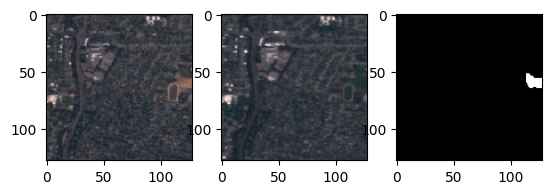

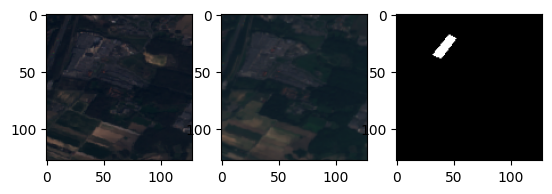

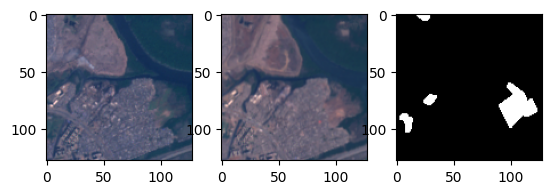

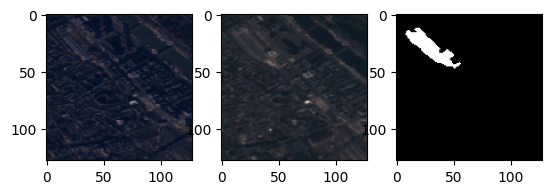

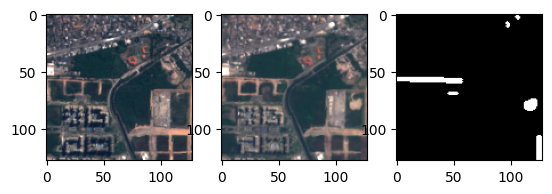

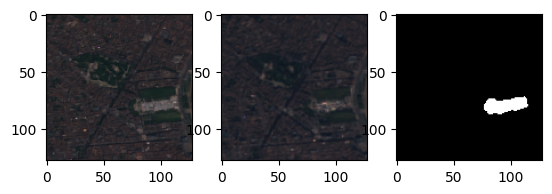

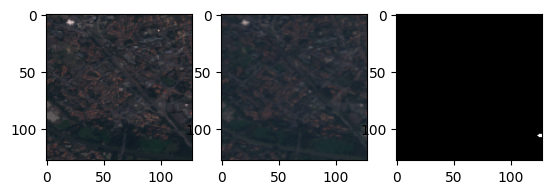

In [4]:
#Simple DataLoader class for our change detection dataset
batch_size = 10

train_dataset= ChangeDetectionDataset(data_dir="data",csv_file="train.csv", batch_size=batch_size, transform=None)
val_dataset = ChangeDetectionDataset(data_dir="data",csv_file="val.csv", batch_size=1, transform=None)
train_loader = DataLoader(batch_size=batch_size, dataset=train_dataset, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, shuffle=True)
#Simple function to display a batch of images

def show_batch(batch):
    img1s, img2s, cms = batch

    for i in range(len(img1s)):
        img1 = img1s[i,:,:,:]
        img2 = img2s[i,:,:,:]
        cm = cms[i,:,:,:]
        fig, ax = plt.subplots(1,3)
        ax[0].imshow(img1.permute(1,2,0))
        ax[1].imshow(img2.permute(1,2,0))
        ax[2].imshow(cm.permute(1,2,0), cmap='gray')
        plt.show()

a = next(iter(train_loader))
show_batch(a)

In [5]:
n_epoch = 100
learning_rate = 0.001
model = Modele()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss, val_loss = [], []
model = model.to(device)

for epoch in range(n_epoch):
    model.train()
    accu = 0

    for img1,img2,cm in train_loader:
        img1,img2,cm = img1.to(device),img2.to(device),cm.to(device)
        #Forward pass
        y_pred = model(img1, img2)
        loss = loss_fn(y_pred, cm)
        accu += loss.item()
        #Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(accu/len(train_loader))

    model.eval()
    for img1,img2,cm in val_loader:
        img1,img2,cm = img1.to(device),img2.to(device),cm.to(device)
        y_pred=model(img1,img2)
        loss = loss_fn(y_pred,cm)
        accu += loss.item()
    val_loss.append(accu/len(val_loader))
    print(f"Train {epoch+1}: {train_loss[-1]} and Valid {epoch}: {val_loss[-1]}")

Train 1: 10.58048963546753 and Valid 0: 16.540279054641722
Train 2: 6.855825662612915 and Valid 1: 11.102315616607665
Train 3: 6.524145126342773 and Valid 2: 13.105955696105957
Train 4: 7.045308828353882 and Valid 3: 14.030715465545654
Train 5: 6.616104602813721 and Valid 4: 8.50738971233368
Train 6: 7.097147703170776 and Valid 5: 14.991002941131592
Train 7: 10.362857580184937 and Valid 6: 12.50920548439026
Train 8: 4.774545907974243 and Valid 7: 10.23339602947235
Train 9: 9.574788093566895 and Valid 8: 11.739144492149354
Train 10: 11.141208171844482 and Valid 9: 11.858088457584381
Train 11: 6.169813394546509 and Valid 10: 10.948696506023406
Train 12: 6.792318344116211 and Valid 11: 8.909869194030762
Train 13: 7.294226884841919 and Valid 12: 15.932270002365112
Train 14: 10.025325298309326 and Valid 13: 16.55766954421997
Train 15: 8.707762002944946 and Valid 14: 15.509261012077332
Train 16: 10.561466336250305 and Valid 15: 11.961653447151184
Train 17: 7.100818872451782 and Valid 16: 19.

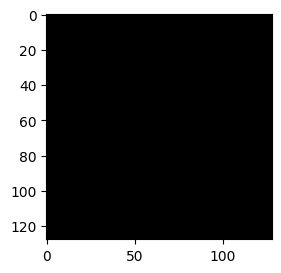

In [8]:
model.cpu()

im1,im2,cm = next(iter(val_loader))
cm_pred = model(im1,im2)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(cm[0].permute(1,2,0), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(cm_pred.detach()[0].permute(1,2,0), cmap='gray')